### Debug

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt

In [167]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [168]:
import numpy as np
import random
from dynaconf import settings

In [285]:
torch.manual_seed(1)

##### Synthetic Data

In [169]:
def get_sin_wave(length, freq):
    t = np.arange(length)
    x = np.sin(2*np.pi * (1/freq) * t)
    return x

In [170]:
X_train = []
y_train = []
for i in range(300):
    example = (get_sin_wave(length=260, freq=random.randint(32, 64)).reshape(1, -1) + 2)/2
#     example = example.T
    start = 0
    end = start + 250
    pred_end = end + 10
    X_train.append(example[:, start:end])
    y_train.append(example[:, end:pred_end])

In [171]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

##### Real Data

In [639]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
real_train_dataset = EEGDataset(train_dataset_csv, 5000, [1], max_num_examples=200, transform=normalize)

X_real_train = []
y_real_train = []
for i in range(len(real_train_dataset)):
    for j in range(3):
        example = real_train_dataset[i].numpy()
        start = random.randint(0, 4700)
        end = start + 250
        pred_end = end + 10
        X_real_train.append(example[:, start:end])
        y_real_train.append(example[:, end:pred_end])

Found 2765 recordings
By set limit only using 200 recordings
Removing recordings of insufficient length...
Removed 4 of 200 recordings. There are now 196 recordings.


In [640]:
dev_dataset_csv = settings.DEV_DATASET_CSV
real_eval_dataset = EEGDataset(dev_dataset_csv, 5000, [1], max_num_examples=-1, transform=normalize)

X_real_eval = []
y_real_eval = []
for i in range(len(real_eval_dataset)):
    for j in range(3):
        example = real_eval_dataset[i].numpy()
        start = random.randint(0, 4700)
        end = start + 250
        pred_end = end + 10
        X_real_eval.append(example[:, start:end])
        y_real_eval.append(example[:, end:pred_end])

Found 345 recordings
By set limit only using 344 recordings
Removing recordings of insufficient length...
Removed 13 of 344 recordings. There are now 331 recordings.


In [641]:
X_train = np.asarray(X_real_train)
y_train = np.asarray(y_real_train)
X_eval = np.asarray(X_real_eval)
y_eval = np.asarray(y_real_eval)

#### Pytorch Model

In [642]:
import torch
import torch.nn as nn
from torch.autograd import Variable

limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units).

In [732]:
class TorchLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=80, num_layers=2, output_size=1, n_predictions=10, dropout=.3):
        super().__init__()
        self.output_size = output_size
        self.n_predictions = n_predictions
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_layer_size, n_predictions * output_size)
        
        self.lstm.reset_parameters = self.reset_parameters
        self.lstm.reset_parameters()


    def forward(self, input_seq):
        out, (_, _) = self.lstm(input_seq)
        preds = self.fc1(out[:,-1].squeeze()).squeeze()
        return preds
    
    def reset_parameters(self):

        for name, param in self.named_parameters():
            if "weight_hh" in name:
                # recurrent weight 
                torch.nn.init.orthogonal_(param)
                
            elif "weight_ih" in name:
                # kernel weight 
                # glorot initialization
                torch.nn.init.xavier_uniform_(param)
            
            elif "bias" in name:
                torch.nn.init.zeros_(param)
                    
#     def reset_parameters(self) -> None:
#         for param in self.parameters():
#             shape = param.shape 
#             if len(shape) == 2:
#                 # it's a recurrent weight
#                 torch.nn.init.orthogonal(param)

#             elif len(shape) == 1:
#                 # it's a bias
#                 torch.nn.init.zeros_(param)
                
#             else:
#                 print("Suspect Weight shape found", shape)
                

In [727]:
model = TorchLSTM()

things to check
- initialization 
- check outputs vs keras

In [728]:
from torch.utils.data import TensorDataset, DataLoader

In [729]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

eval_dataset = TensorDataset(torch.Tensor(X_eval), torch.Tensor(y_eval))
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=True)

In [730]:
def train_model(num_epochs):
    torch_model.train()
    running_losses = []
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            a = torch_model(x.transpose(1,2))
            loss = criteron(a.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            
            running_losses.append(loss.item())
            if i % 50 == 0:
                eval_losses = eval_model()
                eval_losses_avg = sum(eval_losses) / len(eval_losses)
                running_losses_avg = sum(running_losses)/len(running_losses)
                cur_iter = len(train_loader) * epoch + i
                print(f"epoch {epoch} | iter {cur_iter} | Running Loss {running_losses_avg} | Eval Loss {eval_losses_avg}")
                running_losses.clear()
                
def eval_model():
    torch_model.eval()
    running_losses = []
    for i, (x, y) in enumerate(eval_loader):
        with torch.no_grad():
            x, y = x.cuda(), y.cuda()
            a = torch_model(x.transpose(1,2))
            loss = criteron(a.squeeze(), y.squeeze())
            running_losses.append(loss.item())
    torch_model.train()
    return running_losses

In [731]:
torch_model = TorchLSTM(n_predictions=10, hidden_layer_size=80, num_layers=2)
torch_model.cuda()
criteron = nn.MSELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=.01)

In [649]:
train_model(25)

epoch 0 | iter 0 | Running Loss 0.23753511905670166 | Eval Loss 0.13692447217181325
epoch 1 | iter 10 | Running Loss 0.07114486247301102 | Eval Loss 0.04465240053832531
epoch 2 | iter 20 | Running Loss 0.03737402074038983 | Eval Loss 0.01023524219635874
epoch 3 | iter 30 | Running Loss 0.012002526223659516 | Eval Loss 0.0056827308144420385
epoch 4 | iter 40 | Running Loss 0.0064967994578182696 | Eval Loss 0.005148782089236192
epoch 5 | iter 50 | Running Loss 0.006002520024776459 | Eval Loss 0.005981861802865751
epoch 6 | iter 60 | Running Loss 0.005642062169499695 | Eval Loss 0.004707397092715837
epoch 7 | iter 70 | Running Loss 0.0059342732885852454 | Eval Loss 0.004630093084415421
epoch 8 | iter 80 | Running Loss 0.005289773363620043 | Eval Loss 0.004635642035282217
epoch 9 | iter 90 | Running Loss 0.0045886763604357835 | Eval Loss 0.004425622362759896
epoch 10 | iter 100 | Running Loss 0.005008901213295757 | Eval Loss 0.004684951883973554
epoch 11 | iter 110 | Running Loss 0.0049165

In [442]:
torch.save(torch_model.cpu().state_dict(), "./models/saved_models/lstmWIIv01.pt")

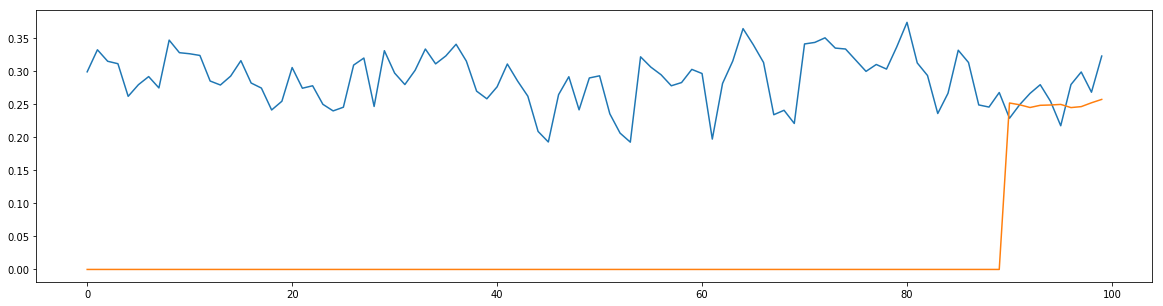

In [672]:
torch_model.eval()
i = random.randint(0, X_train.shape[0])
example = X_train[i]
example = torch.from_numpy(example.reshape(1, 250, 1)).type('torch.FloatTensor').cuda()
pred = torch_model(example).detach().cpu().numpy()
combined = np.concatenate([example[0].cpu().numpy(), y_train[i].T], axis=0).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example.cpu().squeeze()),pred.squeeze()]).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

In [673]:
example[0].shape

torch.Size([250, 1])

In [183]:
y_train[1].shape

(1, 10)

#### Keras Model

In [96]:
import tensorflow

In [97]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping, Callback
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
import numpy as np
import os

Using TensorFlow backend.


In [112]:
k = 80 ** .5

In [651]:
# initializer = tf.keras.initializers.RandomUniform(minval=-k, maxval=k)
initializer = tf.keras.initializers.Orthogonal()

In [676]:
model = Sequential()

model.add(LSTM(
    80,
    input_shape=(None, X_train.shape[2]),
    return_sequences=True,)
#     kernel_initializer=initializer,
#     recurrent_initializer=initializer)
)

model.add(Dropout(.3))

model.add(LSTM(
    80,
    return_sequences=False,
    kernel_initializer=initializer,
    recurrent_initializer=initializer)
)

model.add(Dropout(.3))

model.add(Dense(10))
model.add(Activation('linear'))

model.compile(loss='mse',
               optimizer='adam')

model.fit(X_train,
    y_train.squeeze(),
    batch_size=64,
    epochs=25,
#     validation_split=.2,
)

Epoch 1/25
588/588 [==============================] - 1s 2ms/step - loss: 0.1871
Epoch 2/25
588/588 [==============================] - 0s 78us/step - loss: 0.0577
Epoch 3/25
588/588 [==============================] - 0s 81us/step - loss: 0.0426
Epoch 4/25
588/588 [==============================] - 0s 85us/step - loss: 0.0389
Epoch 5/25
588/588 [==============================] - 0s 95us/step - loss: 0.0331
Epoch 6/25
588/588 [==============================] - 0s 94us/step - loss: 0.0286
Epoch 7/25
588/588 [==============================] - 0s 93us/step - loss: 0.0250
Epoch 8/25
588/588 [==============================] - 0s 96us/step - loss: 0.0226
Epoch 9/25
588/588 [==============================] - 0s 98us/step - loss: 0.0199
Epoch 10/25
588/588 [==============================] - 0s 96us/step - loss: 0.0182
Epoch 11/25
588/588 [==============================] - 0s 97us/step - loss: 0.0164
Epoch 12/25
588/588 [==============================] - 0s 96us/step - loss: 0.0166
Epoch 13/25
58

In [249]:
model

In [229]:
# model.save('../models/saved_models/kerasLSTM')

In [101]:
import tensorflow as tf

In [103]:
# try initializing with same variables
# add pytest (read about it)
# try porting to torch
# try training keras model without fit function 
# https://stackoverflow.com/questions/56915567/keras-vs-pytorch-lstm-different-results

In [230]:
print(torch_model)

TorchLSTM(
  (lstm1): LSTM(1, 80, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(80, 80, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=80, out_features=10, bias=True)
)


In [231]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 80)          105920    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 80)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_8 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                810       
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 158,250
Trainable params: 158,250
Non-trainable params: 0
________________________________________________

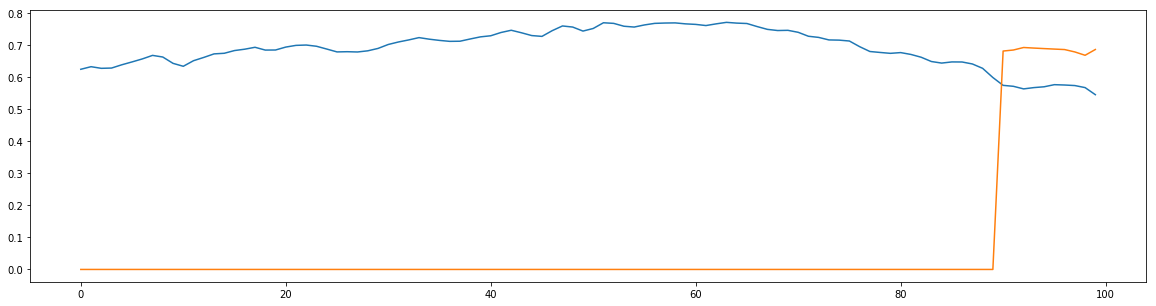

In [725]:
i = random.randint(0, X_train.shape[0])
example = X_train[i]
pred = model.predict(example.reshape(1,1,-1))
combined = np.concatenate([example,y_train[i]], axis=1).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example),pred], axis=1).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

In [ ]:
torch_model.eval()
i = random.randint(0, X_train.shape[0])
example = X_train[i]
example = torch.from_numpy(example.reshape(1, 250, 1)).type('torch.FloatTensor')
pred = torch_model(example).detach().numpy()
combined = np.concatenate([example[0].numpy(), y_train[i].T], axis=0).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example),pred], axis=1).squeeze()

plt.plot(combined[-50:])
plt.plot(combined_zeros[-50:])

In [13]:
import torch
from torch.utils.data import Dataset
from dynaconf import settings
import pandas as pd
from progress.bar import ChargingBar
import multiprocessing as mp

import h5py
import pandas as pd
import torch

def load_eeg_file(filename):
    hdf = h5py.File(filename, "r")
    rec = hdf["record-0"]
    signals = rec["signals"]
    specs = {
        "sample_frequency": rec.attrs["sample_frequency"],
        "number_channels": rec.attrs["number_channels"]
    }
    return signals, specs

def get_recordings_df(csv_file, max_num_examples, print_results_info=True):
        recordings_df = pd.read_csv(csv_file)
        if print_results_info:
            print(f"Found {len(recordings_df)} recordings")

        if max_num_examples is not None:
            recordings_df = recordings_df[:max_num_examples]
            if print_results_info:
                print(f"By set limit only using {len(recordings_df)} recordings")
        
        return recordings_df
    
def normalize(x):
    x_range = x.max()-x.min()
    if x_range == 0:
        return torch.zeros_like(x)
    return (x-x.min())/x_range


class EEGDataset(Dataset):

    def __init__(self, csv_file, length, select_channels, max_num_examples=None, root_dir=None, transform=None, remove_short_recordings=True, filter_freq=False):

        if root_dir is None:
            self.root_dir = settings.DATASET_DIR
        else:
            self.root_dir = root_dir

        self.recordings_df = get_recordings_df(csv_file, max_num_examples)
        self.length = length
        self.select_channels = select_channels
        self.transform = transform
        self.filter_freq = filter_freq

        if remove_short_recordings:
            self.remove_recordings_too_short()

    def __len__(self):
        return len(self.recordings_df)

    def __getitem__(self, idx):
        filename, start_pos = self.recordings_df.iloc[idx, :2]
        signals, _  = load_eeg_file(filename)

        # only keep selected channels
        signals = signals[self.select_channels]
        # only output selected portion
        signals = signals[:, start_pos: start_pos + self.length]
        
#         if self.filter_freq:
#             signals = butter_lowpass_filter2(signals, cutoff=settings.LOW_PASS_FILTER_CUTOFF, fs=settings.FREQUENCY).copy()

        signals = torch.from_numpy(signals).type('torch.FloatTensor')
        if self.transform:
            signals = self.transform(signals)

        return signals

    def recording_is_sufficient_length(self, idx):
        # returns idx if insufficient otherwise None
        cur_recording = self.__getitem__(idx)
        if cur_recording.shape[1] != self.length:
            return idx
        return None
    
    def remove_recordings_too_short(self):

        print("Removing recordings of insufficient length...")
        original_len = self.__len__()

        pool = mp.Pool(mp.cpu_count())
        remove_indices = pool.map(self.recording_is_sufficient_length, list(range(original_len)))
        remove_indices = [i for i in remove_indices if i is not None] # remove all nones

        self.recordings_df = self.recordings_df.drop(remove_indices)
        print(f"Removed {len(remove_indices)} of {original_len} recordings. There are now {self.__len__()} recordings.")
